In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

from datetime import datetime, timedelta
from dateutil.relativedelta import *

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

lastdate_df = pd.DataFrame(most_recent_date, columns=['date'])

lastdate = lastdate_df.to_string()[-10:]

print(f'The most recent date in the data set is {lastdate}')

The most recent date in the data set is 2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
lastdate_dt = datetime.strptime(lastdate,'%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_prev = lastdate_dt + relativedelta(months=-12)
filterdate = one_year_prev.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
last12mnth_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=filterdate).all()

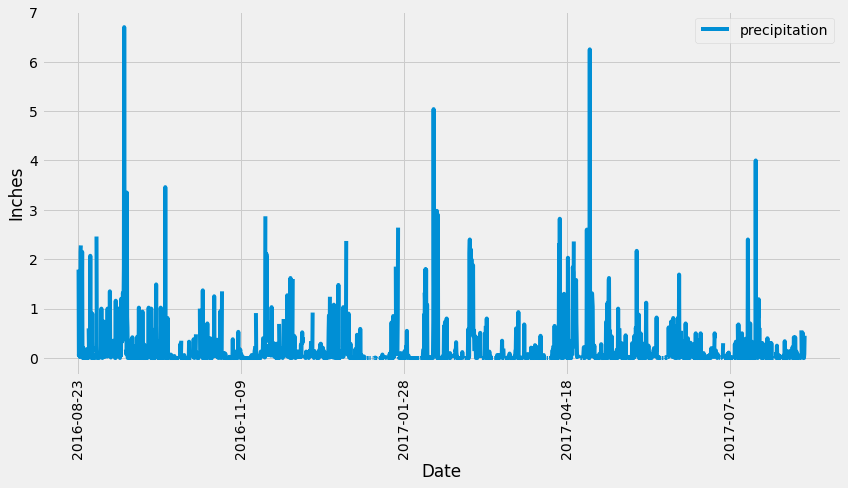

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last12mnth_prcp).set_index('date')

# Sort the dataframe by date
prcp = prcp_df.rename(columns={'prcp':'precipitation'}).sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp.plot(figsize=(12,7))
plt.xticks(rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
print(f'There are {station_count} stations in the data set')

There are 9 stations in the data set


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station)

active_stations_df = pd.DataFrame(active_stations, columns=['station','observations'])\
                                    .sort_values(by='observations', ascending=False)
active_stations_df

,station,observations
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostactive_df = active_stations_df.head(1)
mostactive = mostactive_df.iloc[0]['station']
print(f'The most active station is {mostactive}')

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station==mostactive).all()
for temp in lowest_temp:
    print(f'The lowest temp is {lowest_temp}')

highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station==mostactive).all()
for temp in highest_temp:
    print(f'The highest temp is {highest_temp}')

average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==mostactive).all()
for temp in average_temp:
    print(f'The average temp is {average_temp}')

The most active station is USC00519281
The lowest temp is [(54.0,)]
The highest temp is [(85.0,)]
The average temp is [(71.66378066378067,)]


Text(0.5, 0, 'Temperature')

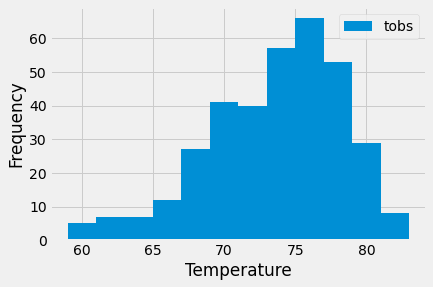

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12mnth_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>=filterdate)\
                                            .filter(Measurement.station==mostactive).all()

temp_df = pd.DataFrame(last12mnth_temp)

ax = temp_df.plot.hist(bins=12)
ax.set_xlabel('Temperature')

# Close session

In [17]:
# Close Session
session.close()